# Multiclass Classification

Let's put all the classification tasks together and start with a multi-class classification problem.

**Multi-class Classification:** Classifying more than one thing or another (e.g. Dog vs Cat vs Chicken)

### Create a toy multi-class dataset

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

Train Data Shape:	(torch.Size([800, 2]), torch.Size([800]))
Test Data Shape:	(torch.Size([200, 2]), torch.Size([200]))


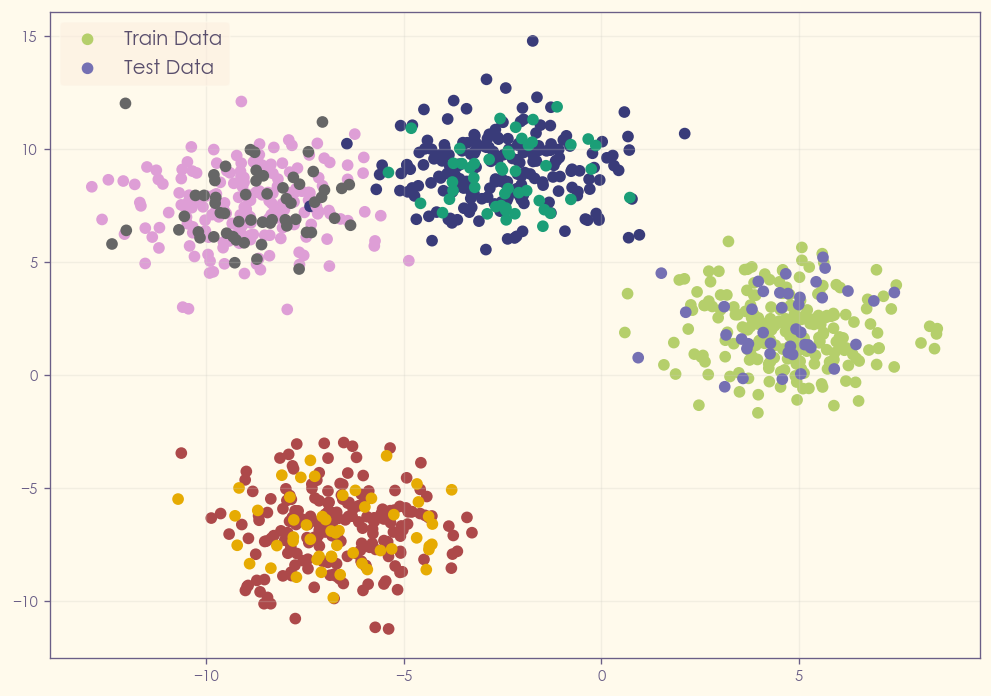

In [2]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

""" 1. Create multiclass data"""
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

""" 2. Turn data into tensors"""
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

""" 3. Split into train and test"""
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

print(f"Train Data Shape:\t{X_blob_train.shape, y_blob_train.shape}")
print(f"Test Data Shape:\t{X_blob_test.shape, y_blob_test.shape}")

""" 4. Plot data and visualize"""
plt.figure(figsize=(10, 7))
plt.scatter(X_blob_train[:, 0], X_blob_train[:, 1], c=y_blob_train, cmap=plt.cm.tab20b, label='Train Data')
plt.scatter(X_blob_test[:, 0], X_blob_test[:, 1], c=y_blob_test, cmap=plt.cm.Dark2, label='Test Data')
plt.legend(prop={"size": 12})

#### Building a multiclass classification model in PyTorch

In [3]:
# Import nn
from torch import nn

# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Active Device:\t{device}")

Active Device:	cuda


In [4]:
# Build a multiclass classification model

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Intializes multiclass classification model.
        
        Args:
            input_features (int):  Number of input features to the model
            output_features (int): Number of output features (number of output classes)
            hidden_units (int):    Number of hidden units between layers. (default is 8)
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
        
    def forward(self, x):
        return self.linear_layer_stack(x)
    
# Create an instance of BlobModel and send it to the target device

model_0 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_0

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

## Loss Function and Optimizer for Multiclass Classification

#### Loss Function for Multiclass Classification: CrossEntropyLoss()
This criterion computes the cross entropy loss between input and target. It is useful when training a classification problem with $C$ classes, where $ C \geq 3$.

**Cross Entropy:** Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label.

In binary classification, where the number of classes N equals 2, cross-entropy can be calculated as:

$$ −(y \cdot log(p) + (1−y) \cdot log(1−p)) $$

In multiclass classification (N > 2), we calculate a separate loss for **each class label per observation** and sum the result. Like as:

$$ -\sum_{c=1}^M y_{o,c}\log(p_{o,c}),\hspace{2em} \textit{for class 'c' and observation 'o'}.  $$

In [5]:
# Create a loss function and optimizer for the multiclass classification model
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.1)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [6]:
# Before starting the model training loop, let's see what our model does initially with test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_blob_test.to(device))

print(y_logits[:10])
print(y_blob_test[:10])

tensor([[ 0.6949,  0.3347,  0.1267,  0.4213],
        [ 1.4056,  0.8656, -0.7032,  0.4017],
        [ 0.3687, -0.0479,  0.2511,  0.3710],
        [ 0.6099,  0.1492,  0.1788,  0.4744],
        [ 1.6121,  0.8986, -0.4470,  0.4720],
        [ 1.5356,  1.0289, -0.8555,  0.3923],
        [ 0.4775,  0.3083,  0.4169,  0.4689],
        [ 1.5761,  0.8319, -0.5443,  0.4314],
        [ 0.5111,  0.0363,  0.1516,  0.3087],
        [ 1.5653,  0.8403, -0.4919,  0.4481]], device='cuda:0')
tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])


In [7]:
# Convert our model's logits into prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.6949,  0.3347,  0.1267,  0.4213],
        [ 1.4056,  0.8656, -0.7032,  0.4017],
        [ 0.3687, -0.0479,  0.2511,  0.3710],
        [ 0.6099,  0.1492,  0.1788,  0.4744],
        [ 1.6121,  0.8986, -0.4470,  0.4720]], device='cuda:0')
tensor([[0.3306, 0.2306, 0.1873, 0.2515],
        [0.4830, 0.2814, 0.0586, 0.1770],
        [0.2816, 0.1857, 0.2504, 0.2823],
        [0.3171, 0.2000, 0.2060, 0.2769],
        [0.5162, 0.2529, 0.0659, 0.1651]], device='cuda:0')


In [8]:
# Convert our models pred_probs into prediction labvels
y_preds = torch.argmax(y_pred_probs, dim=1)
print(f"Model's Initial Prediction Labels without training:\n{y_preds[:10]}")
print(f"\nActual Prediction Labels:\n{y_blob_test[:10]}")
print(f"\nPredicted Results:\n{y_preds[:10] == y_blob_test[:10].to(device)}")

Model's Initial Prediction Labels without training:
tensor([0, 0, 3, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

Actual Prediction Labels:
tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

Predicted Results:
tensor([False, False, False, False,  True, False, False,  True, False,  True],
       device='cuda:0')


In [9]:
# Start building a training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put the data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through the data
for epoch in range(epochs):
    model_0.train()
    """1. Forward Pass"""
    y_logits = model_0(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    """2. Calculate loss"""
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)
    
    """3. Optimizer zero grad"""
    optimizer.zero_grad()
    
    """4. Loss Backward (backpropagation)"""
    loss.backward()
    
    """5. Optimizer Step"""
    optimizer.step()
    
    ## TESTING Loop
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                               y_pred=test_preds)
        
    # Print out the loops
    if epoch % 10 == 0:
        print(f"| Epoch: {epoch:02d} | Loss: {loss:.6f} | Acc: {acc:.4f} % | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} % |")

| Epoch: 00 | Loss: 1.344015 | Acc: 25.2500 % | Test Loss: 1.2392 | Test Acc: 29.0000 % |
| Epoch: 10 | Loss: 0.741511 | Acc: 89.7500 % | Test Loss: 0.6743 | Test Acc: 92.5000 % |
| Epoch: 20 | Loss: 0.343841 | Acc: 96.7500 % | Test Loss: 0.2986 | Test Acc: 98.5000 % |
| Epoch: 30 | Loss: 0.153761 | Acc: 98.3750 % | Test Loss: 0.1351 | Test Acc: 99.0000 % |
| Epoch: 40 | Loss: 0.092188 | Acc: 98.7500 % | Test Loss: 0.0826 | Test Acc: 99.0000 % |
| Epoch: 50 | Loss: 0.067760 | Acc: 98.8750 % | Test Loss: 0.0606 | Test Acc: 99.0000 % |
| Epoch: 60 | Loss: 0.055440 | Acc: 99.0000 % | Test Loss: 0.0489 | Test Acc: 99.0000 % |
| Epoch: 70 | Loss: 0.048223 | Acc: 99.0000 % | Test Loss: 0.0418 | Test Acc: 99.0000 % |
| Epoch: 80 | Loss: 0.043524 | Acc: 99.0000 % | Test Loss: 0.0370 | Test Acc: 99.0000 % |
| Epoch: 90 | Loss: 0.040248 | Acc: 99.0000 % | Test Loss: 0.0335 | Test Acc: 99.0000 % |


In [10]:
# Evaluating multiclass model predictions
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_blob_test)
    
## Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1).argmax(dim=1)
print("Predicted Labels :",y_pred_probs[:10])
print(f"Actual Labels\t : {y_blob_test[:10]}")

Predicted Labels : tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Actual Labels	 : tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')


In [11]:
import requests
from pathlib import Path
import sys  # Import the sys module

if Path(r"..\resources\helper_functions.py").is_file():
    print("`helper_functions.py` already exists, skipping download!")
else:
    print("Downloading `helper_functions.py`...")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open(r"..\resources\helper_functions.py", "wb") as f:
        f.write(request.content)
        
# Get the path to the directory containing helper_functions.py
helper_functions_dir = Path(r"..\resources").resolve()  # Use resolve() for absolute path
print("Path of `helper_functions.py` is located at:\n", helper_functions_dir)
# Add the directory to sys.path
sys.path.append(str(helper_functions_dir))

`helper_functions.py` already exists, skipping download!
Path of `helper_functions.py` is located at:
 C:\Users\MUBASHIR MOHSIN\OneDrive\EDUCATIONAL\SELF-STUDY\ML, DL & CVPR\Journey-with-PyTorch\resources


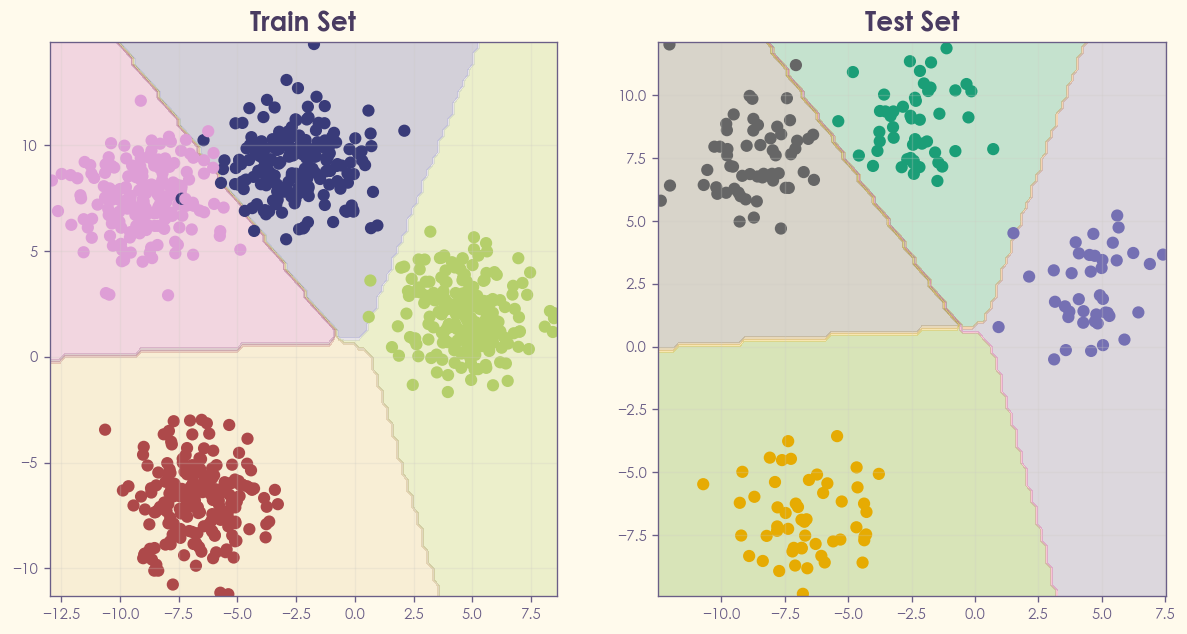

In [12]:
# Let's visualize
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train Set")
plot_decision_boundary(model_0, X_blob_train, y_blob_train, color='tab20b')

plt.subplot(1, 2, 2)
plt.title("Test Set")
plot_decision_boundary(model_0, X_blob_test, y_blob_test, color='Dark2')